In [5]:
import cv2
import numpy as np
import tensorflow as tf
from scipy.misc import imread
import matplotlib.pyplot as plt

import operator
import itertools
import pickle
from ssd import SSD300
from ssd_utils import BBoxUtility

from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, \
                            classification_report, precision_recall_curve, average_precision_score

from keras.utils import np_utils
from keras.preprocessing import image
from keras.backend.tensorflow_backend import set_session
from keras.applications.imagenet_utils import preprocess_input

%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['image.interpolation'] = 'nearest'

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.45
# set_session(tf.Session(config=config))

In [6]:
NUM_CLASSES = 3 # 1 added to include background
CLASSES = ['car', 'pedestrian']
input_shape = (300, 300, 3)

In [7]:
gt = pickle.load(open('groundtruth-encoded.pkl', 'rb'))
base_path = 'checkpoints-nobackground/'
# predictions = pickle.load(open(base_path + 'predictions.pkl', 'rb'))
priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [8]:
# format [xmin, ymin, xmax, ymax, encoded_y]
gt['object-detection-crowdai/1479505369437332886.jpg']

array([[ 0.        ,  0.48666667,  0.11354167,  0.73583333,  1.        ,
         0.        ],
       [ 0.084375  ,  0.495     ,  0.221875  ,  0.66833333,  1.        ,
         0.        ],
       [ 0.1984375 ,  0.49083333,  0.29947917,  0.615     ,  1.        ,
         0.        ],
       [ 0.275     ,  0.4825    ,  0.34270833,  0.58833333,  1.        ,
         0.        ],
       [ 0.66822917,  0.47416667,  0.83802083,  0.645     ,  1.        ,
         0.        ],
       [ 0.59583333,  0.47916667,  0.6828125 ,  0.57583333,  1.        ,
         0.        ],
       [ 0.56458333,  0.485     ,  0.61145833,  0.55      ,  1.        ,
         0.        ],
       [ 0.82760417,  0.4375    ,  0.9859375 ,  0.57333333,  1.        ,
         0.        ],
       [ 0.89322917,  0.44416667,  1.        ,  0.57166667,  1.        ,
         0.        ],
       [ 0.29375   ,  0.47583333,  0.36197917,  0.56666667,  1.        ,
         0.        ],
       [ 0.353125  ,  0.49083333,  0.38125   ,  0.

In [5]:
predictions

{'history': None,
 'pred_prob': array([[[ -1.08119023e+00,  -1.34524679e+00,  -1.75893319e+00, ...,
            1.00000001e-01,   2.00000003e-01,   2.00000003e-01],
         [ -5.85406601e-01,  -1.09328949e+00,  -1.36195004e+00, ...,
            1.00000001e-01,   2.00000003e-01,   2.00000003e-01],
         [ -2.76351881e+00,  -1.14507449e+00,  -4.98436153e-01, ...,
            1.00000001e-01,   2.00000003e-01,   2.00000003e-01],
         ..., 
         [ -3.99081483e-02,   6.73529208e-01,  -2.37694883e+00, ...,
            1.00000001e-01,   2.00000003e-01,   2.00000003e-01],
         [ -2.76190102e-01,   4.26595509e-01,  -1.65282643e+00, ...,
            1.00000001e-01,   2.00000003e-01,   2.00000003e-01],
         [ -1.33538619e-01,   3.78083527e-01,  -2.08733559e+00, ...,
            1.00000001e-01,   2.00000003e-01,   2.00000003e-01]],
 
        [[ -2.40969872e+00,  -1.69983256e+00,  -2.34269357e+00, ...,
            1.00000001e-01,   2.00000003e-01,   2.00000003e-01],
         [ -1

In [4]:
pred_prob = predictions['pred_prob']
train_keys = predictions['train_keys']
val_keys = predictions['val_keys']

In [5]:
def detection_out(predictions, background_label_id=0, keep_top_k=200, confidence_threshold=0.01):
    mbox_loc = predictions[:, :, :4]
    variances = predictions[:, :, -4:]
    mbox_priorbox = predictions[:, :, -8:-4]
    mbox_conf = predictions[:, :, 4:-8]
    results = []
    scores = []
#     print('len(mbox_loc)', len(mbox_loc))
#     print('len(variances)', len(variances))
#     print('len(mbox_priorbox)', len(mbox_priorbox))
#     print('len(mbox_conf)', len(mbox_conf))
    
    for i in range(len(mbox_loc)):
        results.append([])
        scores.append([])
        decode_bbox = bbox_util.decode_boxes(mbox_loc[i],
                                        mbox_priorbox[i], variances[i])
        
        for c in range(bbox_util.num_classes):
            if c == background_label_id:
                continue
            c_confs = mbox_conf[i, :, c]
            all_confs = mbox_conf[i, :, :]
            c_confs_m = c_confs > confidence_threshold
            
            if len(c_confs[c_confs_m]) > 0:
                boxes_to_process = decode_bbox[c_confs_m]
                confs_to_process = c_confs[c_confs_m]
                all_confs_to_process = all_confs[c_confs_m]
                
                feed_dict = {bbox_util.boxes: boxes_to_process,
                             bbox_util.scores: confs_to_process}
                idx = bbox_util.sess.run(bbox_util.nms, feed_dict=feed_dict)
                good_boxes = boxes_to_process[idx]
                confs = confs_to_process[idx][:, None]
    
                equal = np.all(mbox_conf[i, :, :] == mbox_conf[i, ::])
                if not equal:
                    raise ValueError('FUCKKKKKKKKKKKKK')
                                 
                labels = c * np.ones((len(idx), 1))
                c_pred = np.concatenate((labels, confs, good_boxes),
                                        axis=1)

                scores[-1].extend(all_confs_to_process[idx])
                results[-1].extend(c_pred)
            
        if len(results[-1]) > 0:
            results[-1] = np.array(results[-1])
            scores[-1] = np.array(scores[-1])
            argsort = np.argsort(results[-1][:, 1])[::-1]
            results[-1] = results[-1][argsort]
            results[-1] = results[-1][:keep_top_k]
            scores[-1] = scores[-1][argsort]
            scores[-1] = scores[-1][:keep_top_k]

#         print('final scores[-1]', scores[-1])
#         print('final results[-1]', results[-1])
    return results, scores

results, scores = detection_out(pred_prob, keep_top_k=50, confidence_threshold=0.7)

In [8]:
# format: [label, confidence, bounding box points]
results

[array([[ 1.        ,  0.99947029,  0.        ,  0.3866452 ,  0.17504175,
          0.59145033],
        [ 1.        ,  0.99860018,  0.34830108,  0.46173498,  0.44396725,
          0.57625878],
        [ 1.        ,  0.711788  ,  0.44432065,  0.4747752 ,  0.47123423,
          0.52646077],
        [ 1.        ,  0.70360947,  0.42448345,  0.46051693,  0.45959899,
          0.52580148]]),
 array([[ 1.        ,  0.99661177,  0.10990873,  0.45457557,  0.21244872,
          0.55732369],
        [ 1.        ,  0.72310698,  0.25646028,  0.4610554 ,  0.2870076 ,
          0.4998256 ],
        [ 1.        ,  0.71259111,  0.23009229,  0.45833358,  0.2647047 ,
          0.50416535],
        [ 2.        ,  0.71015859,  0.        ,  0.47594178,  0.01810253,
          0.55500829],
        [ 1.        ,  0.70932305,  0.21178839,  0.47768554,  0.25782362,
          0.52939624],
        [ 1.        ,  0.70801419,  0.07018723,  0.47626591,  0.1324522 ,
          0.55257499],
        [ 1.        ,  0.705

In [9]:
len(results[0])

4

In [10]:
# probability of each class, 0 indicating probability of background
scores

[array([[  2.91416713e-04,   9.99470294e-01,   7.00410681e-07,
           2.37608430e-04],
        [  1.39974477e-03,   9.98600185e-01,   3.26897731e-09,
           9.06392827e-08],
        [  2.84721315e-01,   7.11787999e-01,   6.17797021e-04,
           2.87293224e-03],
        [  2.96261013e-01,   7.03609467e-01,   7.42542616e-05,
           5.52879064e-05]], dtype=float32),
 array([[  3.35948705e-03,   9.96611774e-01,   4.91398964e-07,
           2.82241344e-05],
        [  2.76233733e-01,   7.23106980e-01,   1.13749185e-04,
           5.45513583e-04],
        [  2.85624027e-01,   7.12591112e-01,   1.73733017e-04,
           1.61121308e-03],
        [  2.73700178e-01,   1.59294941e-02,   7.10158587e-01,
           2.11730483e-04],
        [  2.89782703e-01,   7.09323049e-01,   4.79295035e-04,
           4.15008370e-04],
        [  2.91865766e-01,   7.08014190e-01,   1.10139597e-04,
           9.96955077e-06],
        [  2.91355520e-01,   7.05004692e-01,   7.03832367e-04,
          

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1), decimals=4)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
def buildY(results):
    y_true = []
    y_pred = []

    for i, k in enumerate(val_keys):
        y_onehot = gt[k][:, 4:]
        y = np.argmax(y_onehot, axis=1)

        result = results[i]
        if len(result) > 0:
            pred = result[:, 0].astype(int)
            pred -= 1 # label starts at 0, ignoring background label

            size = min(len(pred), len(y))
            y_true.extend(y[:size])
            y_pred.extend(pred[:size])
            
    return y_true, y_pred

def buildYWithProb(results, scores):
    less_pred_count = 0
    more_pred_count = 0
    y_true = []
    y_pred = []
    y_scores = []
    for i, k in enumerate(val_keys):
        y_onehot = gt[k][:, 4:]
        c = np.zeros((len(y_onehot), 1))
        y_onehot = np.concatenate((c, y_onehot), axis=1) # add 0 for background
        y = np.argmax(y_onehot, axis=1).tolist()

        score = scores[i]
        pred = results[i]

        pred_length = len(pred)
        y_length = len(y)

        if pred_length > 0:
            pred = pred[:, 0].astype(int)

        if pred_length > y_length:
            more_pred_count += 1
            z = np.zeros(pred_length, dtype=int)
            z[:y_length] = y
            y = z
        elif pred_length < y_length:
            less_pred_count += 1
            z = np.zeros(y_length, dtype=int)
            z_scores = np.array([[0] * 4] * y_length, dtype=float)
            if pred_length != 0:
                z_scores[:pred_length] = score
            z[:pred_length] = pred
            score = z_scores
            pred = z

        y_true.extend(y)
        y_pred.extend(pred)
        y_scores.extend(score)
    
    return y_true, y_pred, np.array(y_scores)
    

## Confustion Matrix

In [13]:
results, scores = detection_out(pred_prob, keep_top_k=50, confidence_threshold=0.7)
print(len(results))
print(len(val_keys))
y_true, y_pred = buildY(results)
    

print('len(y_true)', len(y_true))
print('len(y_pred)', len(y_pred))
# print('y_true', y_true)
# print('y_pred', y_pred)
print('y_true', np.unique(y_true))
print('y_pred', np.unique(y_pred))

4437
4437
len(y_true) 20008
len(y_pred) 20008
y_true [0 1 2]
y_pred [0 1 2]


Confusion matrix, without normalization
[[15395   830   847]
 [ 1007   947    65]
 [  629    62   226]]


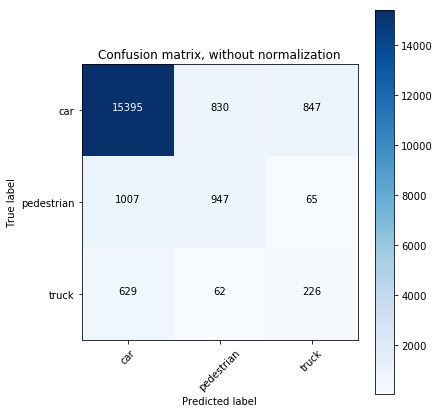

In [15]:
# plt.figure()
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes=['car', 'pedestrian', 'truck'],
                      title='Confusion matrix, without normalization')

plt.show()

In [16]:
results, scores = detection_out(pred_prob, keep_top_k=50, confidence_threshold=0.7)
y_true, y_pred, y_scores = buildYWithProb(results, scores)

print('len(y_scores)', len(y_scores))
print('len(y_true)', len(y_true))
print('len(y_pred)', len(y_pred))
# print('y_true', y_true)
# print('y_pred', y_pred)
# print('y_scores', np.array(y_scores))
print('y_true', np.unique(y_true))
print('y_pred', np.unique(y_pred))

len(y_scores) 38886
len(y_true) 38886
len(y_pred) 38886
y_true [0 1 2 3]
y_pred [0 1 2 3]


Confusion matrix, without normalization
[[    0  7751  1403   334]
 [ 7867 15395   830   847]
 [ 1001  1007   947    65]
 [  522   629    62   226]]


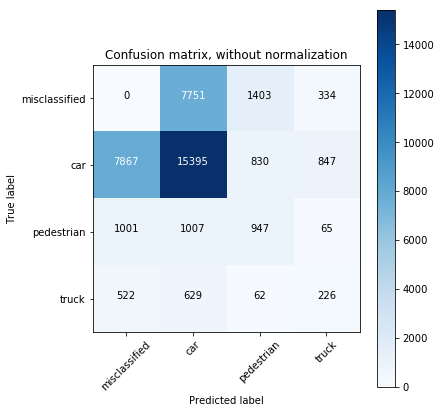

In [18]:
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes=['misclassified', 'car', 'pedestrian', 'truck'],
                      title='Confusion matrix, without normalization')

plt.show()

Normalized confusion matrix
[[ 0.      0.3108  0.4646  0.2321]
 [ 0.8292  0.6173  0.2748  0.5886]
 [ 0.1055  0.0404  0.3136  0.0452]
 [ 0.055   0.0252  0.0205  0.1571]]


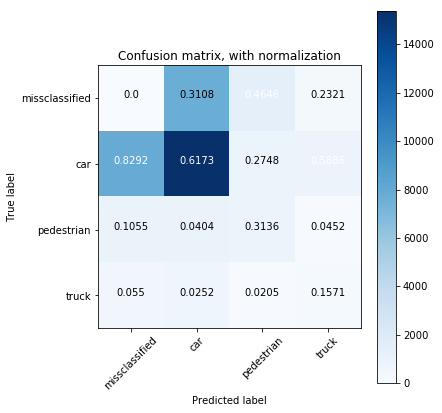

In [19]:
plot_confusion_matrix(cnf_matrix, normalize=True, classes=['missclassified', 'car', 'pedestrian', 'truck'],
                      title='Confusion matrix, with normalization')

plt.show()

# Precision, Recall and F1-Score

In [20]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [21]:
y_true = []
y_pred = []

for i, k in enumerate(val_keys[:2]):
    y_onehot = gt[k][:, 4:]
    c = np.zeros((len(y_onehot), 1))
    y_onehot = np.concatenate((c, y_onehot), axis=1) # add 0 for background
    y = np.argmax(y_onehot, axis=1).tolist()
    
    pred = results[i]
    
    pred_length = len(pred)
    y_length = len(y)
    
    if pred_length > 0:
        pred = pred[:, 0].astype(int).tolist()
        
    if pred_length > y_length:
        z = np.zeros(pred_length, dtype=int)
        z[:y_length] = y
        y = z.tolist()
    elif pred_length < y_length:
        z = np.zeros(y_length, dtype=int)
        z[:pred_length] = pred
        pred = z

    y_true.append(y)
    y_pred.append(pred)

In [22]:
mapk(y_true, y_pred, k=10)

0.1388888888888889

In [23]:
mapk(y_true, y_pred, k=5)

0.20000000000000001

In [24]:
results, scores = detection_out(pred_prob, keep_top_k=50, confidence_threshold=0.7)
y_true, y_pred, _ = buildYWithProb(results, scores)
precision_score(y_true, y_pred, average='micro')

0.42606593632669854

In [25]:
results, scores = detection_out(pred_prob, keep_top_k=50, confidence_threshold=0.7)
recall_score(y_true, y_pred, average='weighted')
# precision_recall_curve([1, 2, 1], [0, 0, 0], average='weighted') # take a look at this case

0.42606593632669854

In [26]:
precision = dict()
recall = dict()
average_precision = dict()

y_true_onehot = np_utils.to_categorical(y_true, NUM_CLASSES)

for i in range(NUM_CLASSES):
    precision[i], recall[i], _ = precision_recall_curve(y_true_onehot[:, i],
                                                        y_scores[:, i])
    average_precision[i] = average_precision_score(y_true_onehot[:, i], y_scores[:, i])

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_onehot.ravel(), y_scores.ravel())
average_precision["micro"] = average_precision_score(y_true_onehot, y_scores,
                                                     average="micro")

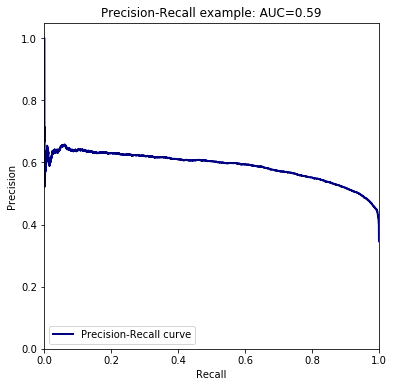

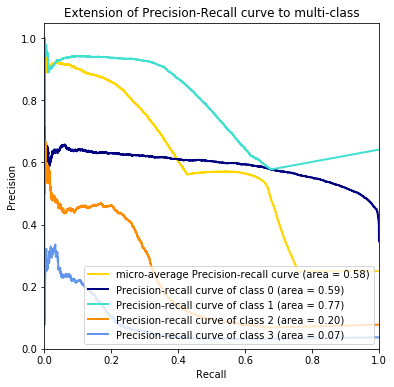

In [27]:
# Plot Precision-Recall curve
lw = 2
colors = itertools.cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.clf()
plt.plot(recall[0], precision[0], lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.show()

# Plot Precision-Recall curve for each class
plt.clf()
plt.plot(recall["micro"], precision["micro"], color='gold', lw=lw,
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(recall[i], precision[i], color=color, lw=lw,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(i, average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.show()

In [28]:
print(classification_report(y_true, y_pred, target_names=['misclassfied', 'car', 'pedestrian', 'truck']))

              precision    recall  f1-score   support

misclassfied       0.00      0.00      0.00      9488
         car       0.62      0.62      0.62     24939
  pedestrian       0.29      0.31      0.30      3020
       truck       0.15      0.16      0.16      1439

 avg / total       0.43      0.43      0.43     38886



In [29]:
y_true_onehot = np_utils.to_categorical(y_true, NUM_CLASSES)
roc_auc_score(y_true_onehot, y_scores)

0.62398537619475536

# Predictions

In [29]:
def build_inputs(keys):
    inputs = []
    images = []
    path_prefix = 'resources/udacity-dataset/'
    for key in keys:
        img_path = path_prefix + key
        img = image.load_img(img_path, target_size=(300, 300))
        img = image.img_to_array(img)
        images.append(imread(img_path))
        inputs.append(img.copy())
    inputs = preprocess_input(np.array(inputs))
    return inputs, images

def plot(inputs, images):
    preds = model.predict(inputs, batch_size=1, verbose=1)
    results = bbox_util.detection_out(preds)

    for i, img in enumerate(images):
        # Parse the outputs.
        det_label = results[i][:, 0]
        det_conf = results[i][:, 1]
        det_xmin = results[i][:, 2]
        det_ymin = results[i][:, 3]
        det_xmax = results[i][:, 4]
        det_ymax = results[i][:, 5]

        # Get detections with confidence higher than 0.6.
        top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.9]

        top_conf = det_conf[top_indices]
        top_label_indices = det_label[top_indices].tolist()
        top_xmin = det_xmin[top_indices]
        top_ymin = det_ymin[top_indices]
        top_xmax = det_xmax[top_indices]
        top_ymax = det_ymax[top_indices]

        colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

        plt.imshow(img / 255.)
        currentAxis = plt.gca()

        for i in range(top_conf.shape[0]):
            xmin = int(round(top_xmin[i] * img.shape[1]))
            ymin = int(round(top_ymin[i] * img.shape[0]))
            xmax = int(round(top_xmax[i] * img.shape[1]))
            ymax = int(round(top_ymax[i] * img.shape[0]))
            score = top_conf[i]
            label = int(top_label_indices[i])
#             label_name = CLASSES[label - 1]
            label_name = label - 1
            display_txt = '{:0.2f}, {}'.format(score, label_name)
            coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
            color = colors[label]
            currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
            currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

        plt.show()

In [11]:
input_shape=(300, 300, 3)
NUM_CLASSES = 3
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('weights.48-1.13.hdf5', by_name=True)
bbox_util = BBoxUtility(NUM_CLASSES, priors)

1/1 [==============================] - 1s


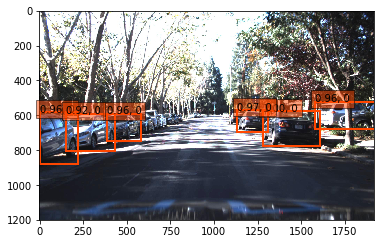

In [30]:
keys = ['object-detection-crowdai/1479505369437332886.jpg']
inputs, images = build_inputs(keys)

plot(inputs, images)

10/10 [==============================] - 17s    


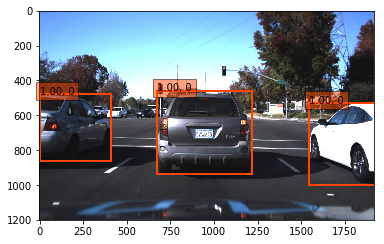

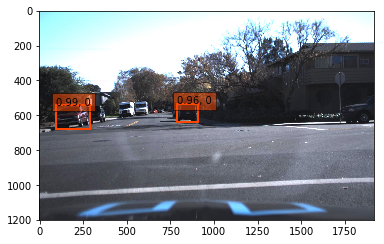

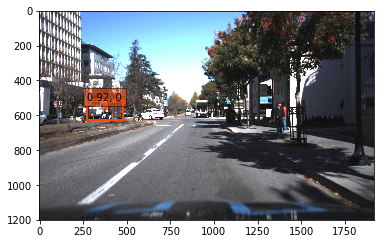

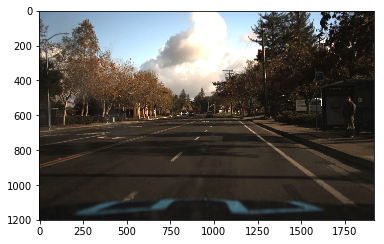

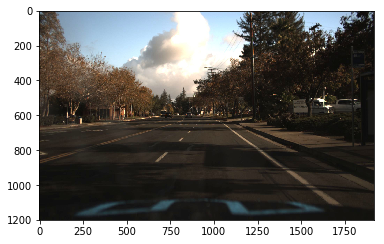

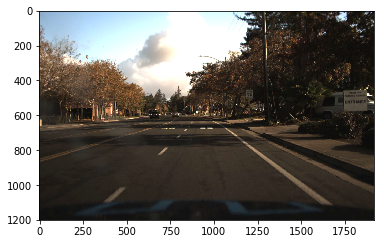

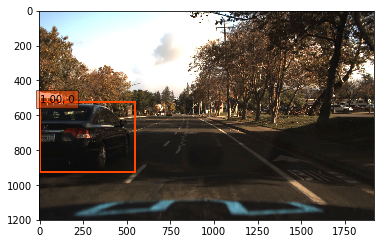

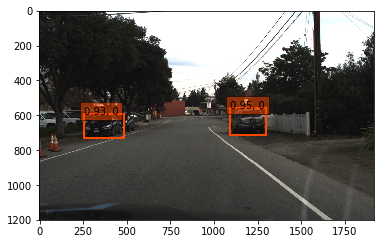

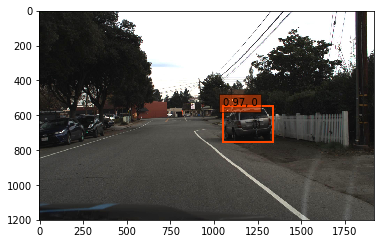

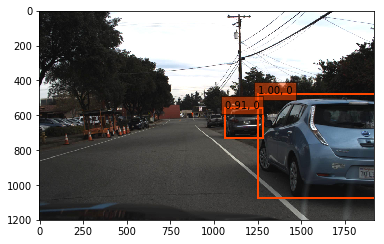

In [31]:
keys = ['object-detection-crowdai/1479502217225257061.jpg', 'object-detection-crowdai/1479498371963069978.jpg', 
       'object-detection-crowdai/1479503036282378933.jpg', 'object-dataset/1478019952686311006.jpg', 'object-dataset/1478019953689774621.jpg',
       'object-dataset/1478019955185244088.jpg', 'object-dataset/1478019959681353555.jpg', 'object-dataset/1478901535246276321.jpg',
       'object-dataset/1478901536388465963.jpg', 'object-dataset/1478901532389636298.jpg']
inputs, images = build_inputs(keys)

plot(inputs, images)

In [32]:
from random import shuffle
keys = sorted(gt.keys())
shuffle(keys)
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]

['object-dataset/1478899855082761665.jpg', 'object-detection-crowdai/1479504330366436549.jpg', 'object-detection-crowdai/1479501729692847065.jpg', 'object-dataset/1478898008674085287.jpg', 'object-dataset/1478898385726303289.jpg', 'object-dataset/1478896925509187138.jpg', 'object-dataset/1478895331611742960.jpg', 'object-dataset/1478900828560398777.jpg', 'object-detection-crowdai/1479504224862874415.jpg', 'object-dataset/1478897031769090925.jpg']
10/10 [==============================] - 17s    


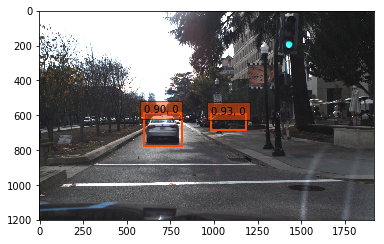

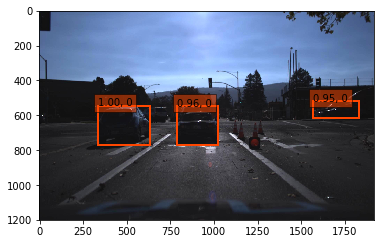

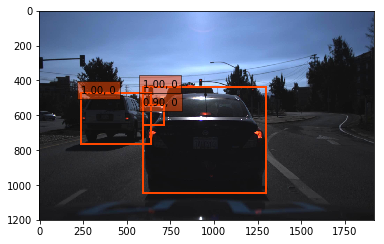

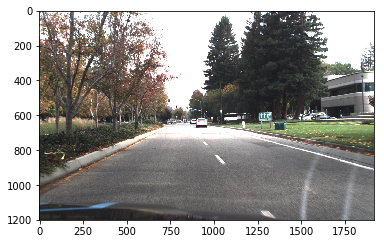

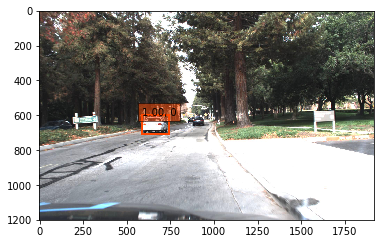

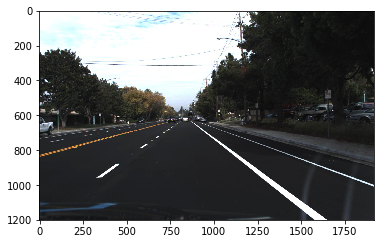

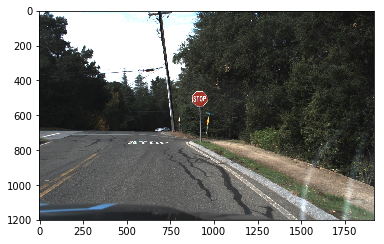

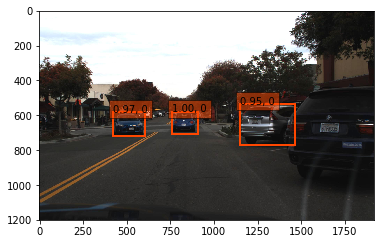

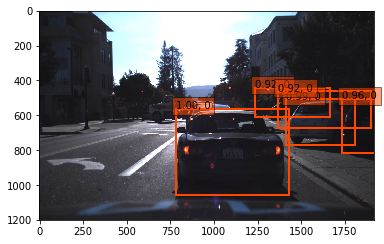

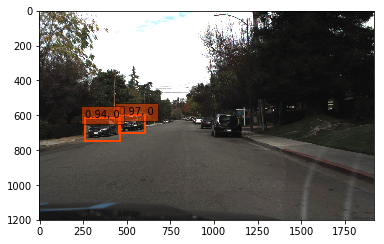

In [33]:
inputs = []
images = []
keys = list(map(lambda i: val_keys[i], range(60, 70)))
print(list(keys))
inputs, images = build_inputs(keys)
plot(inputs, images)

In [27]:
import matplotlib.image as mpimg

def plot_gt(images, gt=[]):
    for i, img in enumerate(images):

        for row in gt:
            xmin = int(round(row[0] * img.shape[1]))
            ymin = int(round(row[1] * img.shape[0]))
            xmax = int(round(row[2] * img.shape[1]))
            ymax = int(round(row[3] * img.shape[0]))
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax),(0, 255, 0), 3)

        plt.imshow(img / 255.)
        plt.show()

def plot_pred(inputs, images, gt=[]):
    preds = model.predict(inputs, batch_size=1, verbose=1)
    results = bbox_util.detection_out(preds)
    print(results)
    for i, img in enumerate(images):
        # Parse the outputs.
        det_label = results[i][:, 0]
        det_conf = results[i][:, 1]
        det_xmin = results[i][:, 2]
        det_ymin = results[i][:, 3]
        det_xmax = results[i][:, 4]
        det_ymax = results[i][:, 5]

        # Get detections with confidence higher than 0.6.
        top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.7]

        top_conf = det_conf[top_indices]
        top_label_indices = det_label[top_indices].tolist()
        top_xmin = det_xmin[top_indices]
        top_ymin = det_ymin[top_indices]
        top_xmax = det_xmax[top_indices]
        top_ymax = det_ymax[top_indices]

        colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
        
        currentAxis = plt.gca()
#         print('len', len(pred), len(top_conf))
        for i in range(top_conf.shape[0]):
            xmin = int(round(top_xmin[i] * img.shape[1]))
            ymin = int(round(top_ymin[i] * img.shape[0]))
            xmax = int(round(top_xmax[i] * img.shape[1]))
            ymax = int(round(top_ymax[i] * img.shape[0]))
            score = top_conf[i]
            label = int(top_label_indices[i])
            label_name = CLASSES[label - 1]
            display_txt = '{:0.2f}, {}'.format(score, label_name)
            coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
            color = colors[label]
            currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
            currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
            
#         for row in gt:
#             xmin = int(round(row[0] * img.shape[1]))
#             ymin = int(round(row[1] * img.shape[0]))
#             xmax = int(round(row[2] * img.shape[1]))
#             ymax = int(round(row[3] * img.shape[0]))
#             cv2.rectangle(img, (xmin, ymin), (xmax, ymax),(0, 255, 0), 3)

        plt.imshow(img / 255.)
        plt.show()

In [28]:
k = val_keys[:1][0]
inputs, images = build_inputs(val_keys[:1])
plot_pred(inputs, images, gt[k])

NameError: name 'val_keys' is not defined

1/1 [==============================] - 0s
[array([[ 1.        ,  0.02490502,  0.38178486,  0.4577885 ,  0.40496916,
         0.51017106],
       [ 2.        ,  0.02068295,  0.20439565,  0.44510025,  0.25658837,
         0.50228137],
       [ 2.        ,  0.02050075,  0.38178486,  0.4577885 ,  0.40496916,
         0.51017106],
       [ 2.        ,  0.01803392,  0.05625729,  0.41930705,  0.1334022 ,
         0.55478305],
       [ 1.        ,  0.01787028,  0.30527326,  0.44421276,  0.35373172,
         0.50377852],
       [ 1.        ,  0.0174972 ,  0.25608921,  0.46404237,  0.27991408,
         0.50712681],
       [ 2.        ,  0.01735546,  0.24679573,  0.46797958,  0.27133784,
         0.49959889],
       [ 1.        ,  0.01717375,  0.71129847,  0.44679239,  0.74473476,
         0.49469402],
       [ 1.        ,  0.01702988,  0.24679573,  0.46797958,  0.27133784,
         0.49959889],
       [ 2.        ,  0.0168166 ,  0.26963532,  0.46417224,  0.3222    ,
         0.5194906 ],
       

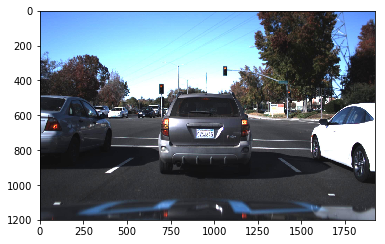

In [29]:
keys = ['object-detection-crowdai/1479502217225257061.jpg']
inputs, images = build_inputs(keys)
plot_pred(inputs, images, gt[keys[0]])

In [12]:
def iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
#     print('xA', xA)
#     print('yA', yA)
#     print('xB', xB)
#     print('yB', yB)
    epsilon = 1e-8
 
    # compute the area of intersection rectangle
    x = (xB - xA + epsilon)
    y = (yB - yA + epsilon)
    if x <= epsilon or y <= epsilon:
        interArea = 0
    else:
        interArea = x * y
#     print('interArea', interArea)
    
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
#     print('boxAArea', boxAArea)
#     print('boxBArea', boxBArea)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
 
    # return the intersection over union value
    return iou

def denormalize(val, w, h):
    return (val[0]*w, val[1]*h, val[2]*w, val[3]*h)

boxA = (0, 0, 1, 1)
boxB = (0.5, 0.5, 1.5, 1.5)
iou(boxA, boxB)

0.032258065848074946

In [150]:
def measure(keys):
    # predict
    inputs, images = build_inputs(keys)
    preds = model.predict(inputs, batch_size=1, verbose=1)
    results = bbox_util.detection_out(preds, keep_top_k=50, confidence_threshold=0.7)
    
    for i, k in enumerate(keys):
        TP = 0
        FP = 0
        FN = 0
        img = images[i]
        y_onehot = gt[k]
        print('key', k)
        print('y_onehot count', len(y_onehot))
        print('pred count', len(results[i]))

        if len(results[i]) == 0:
            pred_bb = []
            y_prob = []
            y_pred = []
        else:
            pred_bb = results[i][:, 2:]
            y_prob = results[i][:, 1]
            y_pred = results[i][:, 0].astype(int) - 1 # -1 because we ignore background class, so class 0 becomes car

        gt_bb = gt[k][:, :4]
        y_gt = np.argmax(gt[k][:, 4:], axis=1)

        FN += abs(len(y_pred) - len(y_gt))

        d = dict()
        for j in range(len(pred_bb)):
            prob = y_prob[j]
            label = CLASSES[y_pred[j]]
            pred_bb_dnorm = denormalize(pred_bb[j], img.shape[1], img.shape[0])

            for k in range(len(gt_bb)):
                gt_bb_dnorm = denormalize(gt_bb[k], img.shape[1], img.shape[0])
                iou_val = iou(gt_bb_dnorm, pred_bb_dnorm)
                if iou_val > 0:
                    #(j, k): j=prediction index, k=groundtruth index
                    d[(j, k)] = iou_val
                    
        d_sorted = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
        gt_detected = set()
        pred_detected = set()

        for k, v in d_sorted:
            print(k, v)
        print('---------------------------')

        for k, v in d_sorted:
            pred_idx, gt_idx = k

            if gt_idx not in gt_detected:
                
                if pred_idx not in pred_detected:
                    print('y_gt', y_gt[gt_idx])
                    print('y_pred', y_pred[pred_idx])
                    
                    if y_gt[gt_idx] == y_pred[pred_idx]:
                        TP += 1
                    else:
                        FP += 1
                    print(gt_idx, 'is selected with pred', pred_idx)
                    gt_detected.add(gt_idx)
                    pred_detected.add(pred_idx)
            elif pred_idx not in pred_detected:
                FP += 1
                print('No pred', pred_idx, 'but groundtruth', gt_idx, 'is detected already', (k, v))
                    
                    
        print('TP:', TP)
        print('FP:', FP)
        print('FN:', FN)

In [11]:
keys = ['object-dataset/1478895407021175056.jpg']
inputs, images = build_inputs(keys)
plot_gt(images, gt[keys[0]])

NameError: name 'plot_gt' is not defined

In [ ]:
inputs, images = build_inputs(keys)
plot_pred(inputs, images, gt[keys[0]])

In [153]:
measure(keys)

1/1 [==============================] - 0s
key object-dataset/1478895407021175056.jpg
y_onehot count 2
pred count 0
---------------------------
TP: 0
FP: 0
FN: 2


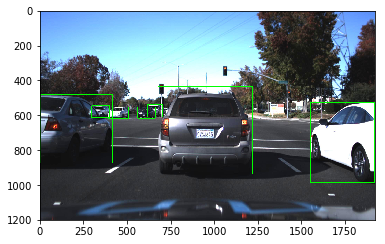

In [154]:
keys = ['object-detection-crowdai/1479502217225257061.jpg']
inputs, images = build_inputs(keys)
plot_gt(images, gt[keys[0]])

1/1 [==============================] - 0s


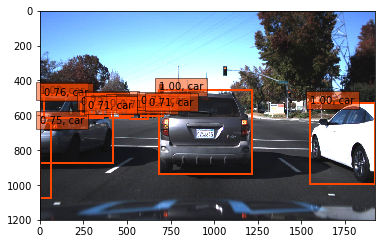

In [155]:
inputs, images = build_inputs(keys)
plot_pred(inputs, images, gt[keys[0]])

In [156]:
measure(keys)

1/1 [==============================] - 0s
key object-detection-crowdai/1479502217225257061.jpg
y_onehot count 7
pred count 13
(0, 1) 0.966048340506
(2, 2) 0.947932123246
(1, 0) 0.947920408764
(7, 4) 0.71115073732
(11, 6) 0.643504822877
(4, 5) 0.52185697641
(10, 6) 0.446814122306
(12, 5) 0.434054680646
(10, 3) 0.398766075794
(8, 3) 0.391241391557
(9, 4) 0.238590909391
(3, 1) 0.203118489094
(11, 3) 0.151521191432
(5, 1) 0.0844548812529
(6, 5) 0.0600402047351
(4, 1) 0.0450520727018
(0, 5) 0.0413319458603
(12, 1) 0.0282531039064
(6, 1) 0.0239489851156
(8, 6) 0.022757207259
(0, 4) 0.0110707868412
(11, 0) 0.00709974166082
(7, 1) 0.0061913617531
(1, 6) 0.00561904182386
(10, 0) 0.000647340242498
(7, 5) 0.000116209984543
---------------------------
y_gt 0
y_pred 0
1 is selected with pred 0
y_gt 0
y_pred 0
2 is selected with pred 2
y_gt 0
y_pred 0
0 is selected with pred 1
y_gt 0
y_pred 0
4 is selected with pred 7
y_gt 0
y_pred 0
6 is selected with pred 11
y_gt 0
y_pred 0
5 is selected with pred

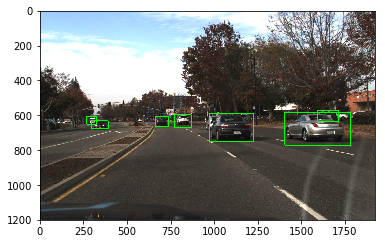

In [131]:
keys = ['object-dataset/1478896783257516407.jpg']
inputs, images = build_inputs(keys)
plot_gt(images, gt[keys[0]])

1/1 [==============================] - 0s


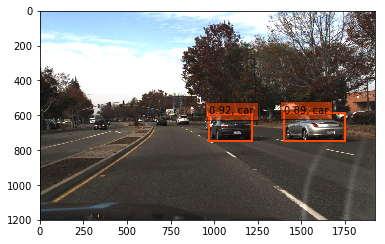

In [132]:
inputs, images = build_inputs(keys)
plot_pred(inputs, images, gt[keys[0]])

In [133]:
measure(['object-dataset/1478896783257516407.jpg'])

1/1 [==============================] - 0s
key object-dataset/1478896783257516407.jpg
y_onehot count 7
pred count 2
(0, 4) 0.936556049486
(1, 5) 0.745590402522
(1, 6) 0.102353660188
---------------------------
4 is selected with pred 0
5 is selected with pred 1
TP: 2
FP: 0
FN: 5


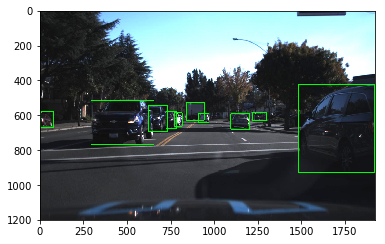

In [157]:
keys = ['object-detection-crowdai/1479505929977588157.jpg']
inputs, images = build_inputs(keys)
plot_gt(images, gt[keys[0]])

1/1 [==============================] - 0s


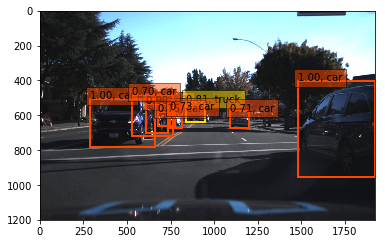

In [158]:
inputs, images = build_inputs(keys)
plot_pred(inputs, images, gt[keys[0]])

In [159]:
measure(keys)

1/1 [==============================] - 0s
key object-detection-crowdai/1479505929977588157.jpg
y_onehot count 10
pred count 8
(0, 0) 0.896091949116
(1, 3) 0.895897731457
(3, 7) 0.852828778435
(2, 4) 0.78597713948
(6, 1) 0.703358122535
(5, 6) 0.488214778116
(4, 5) 0.45637956249
(5, 5) 0.324520043153
(7, 4) 0.289733792263
(4, 4) 0.217227331897
(7, 3) 0.206427305533
(3, 2) 0.128777009722
(7, 5) 0.0704735308146
(2, 3) 0.0694514979819
(4, 6) 0.0618401841906
(1, 4) 0.0489896980526
(2, 5) 0.0379435560218
---------------------------
y_gt 0
y_pred 0
0 is selected with pred 0
y_gt 0
y_pred 0
3 is selected with pred 1
y_gt 2
y_pred 2
7 is selected with pred 3
y_gt 0
y_pred 0
4 is selected with pred 2
y_gt 0
y_pred 0
1 is selected with pred 6
y_gt 0
y_pred 0
6 is selected with pred 5
y_gt 0
y_pred 0
5 is selected with pred 4
No pred 7 but groundtruth 4 is detected already ((7, 4), 0.28973379226274387)
No pred 7 but groundtruth 3 is detected already ((7, 3), 0.20642730553278024)
No pred 7 but groun

In [137]:
measure(np.array(val_keys)[range(40, 50)])

 8/10 [=======================>......] - ETA: 0skey object-dataset/1478020633205868287.jpg
y_onehot count 1
pred count 1
(0, 0) 0.827113541685
---------------------------
0 is selected with pred 0
TP: 1
FP: 0
FN: 0
key object-dataset/1478901476974216608.jpg
y_onehot count 10
pred count 1
(0, 1) 0.774275215927
(0, 0) 0.703161999527
---------------------------
1 is selected with pred 0
TP: 1
FP: 0
FN: 9
key object-dataset/1478895407021175056.jpg
y_onehot count 2
pred count 0
---------------------------
TP: 0
FP: 0
FN: 2
key object-dataset/1478899543158243104.jpg
y_onehot count 11
pred count 28
(0, 9) 0.837127843591
(3, 10) 0.79732208224
(5, 6) 0.753543752438
(11, 5) 0.748687800582
(4, 1) 0.725387214878
(7, 2) 0.711021505947
(18, 4) 0.707284133095
(2, 0) 0.666875668095
(8, 7) 0.633950024231
(10, 7) 0.547698793054
(1, 8) 0.546575836055
(6, 3) 0.545067914474
(7, 3) 0.533641284661
(17, 10) 0.49540

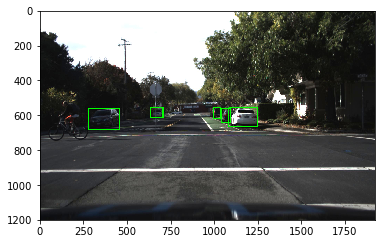

In [138]:
keys = ['object-dataset/1478021874581175763.jpg']
inputs, images = build_inputs(keys)
plot_gt(images, gt[keys[0]])

1/1 [==============================] - 0s


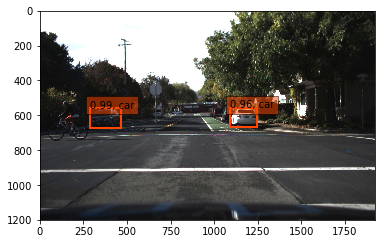

In [139]:
inputs, images = build_inputs(keys)
plot_pred(inputs, images, gt[keys[0]])

In [140]:
measure(keys)

1/1 [==============================] - 0s
key object-dataset/1478021874581175763.jpg
y_onehot count 6
pred count 2
(1, 5) 0.861013576564
(0, 0) 0.785027239209
(1, 4) 0.00465877514385
---------------------------
5 is selected with pred 1
0 is selected with pred 0
TP: 2
FP: 0
FN: 4


In [13]:
iou((1551.7339324951172, 744.94636058807373, 1781.6526031494141, 1064.3930196762085), (504.0, 569.0, 561.0, 627.0))

0.0